**7장 - 앙상블 학습과 랜덤 포레스트**

_이 노트북에는 7장의 모든 샘플 코드와 연습 문제에 대한 솔루션이 포함되어 있습니다._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/rickiepark/handson-ml3/blob/main/07_ensemble_learning_and_random_forests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# 설정

이 프로젝트에는 파이썬 3.7 이상이 필요합니다:

In [1]:
import sys

assert sys.version_info >= (3, 7)

또한 사이킷런 ≥ 1.0.1이 필요합니다:

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

이전 챕터에서와 마찬가지로 기본 글꼴 크기를 정의하여 그림을 더 예쁘게 만들어 보겠습니다:

In [3]:
# import matplotlib.pyplot as plt

# plt.rc('font', size=14)
# plt.rc('axes', labelsize=14, titlesize=14)
# plt.rc('legend', fontsize=14)
# plt.rc('xtick', labelsize=10)
# plt.rc('ytick', labelsize=10)

# import sys
# # 코랩의 경우 나눔 폰트를 설치합니다.
# if 'google.colab' in sys.modules:
#     !sudo apt-get -qq -y install fonts-nanum
#     import matplotlib.font_manager as fm
#     font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
#     for fpath in font_files:
#         fm.fontManager.addfont(fpath)

# # 나눔 폰트를 사용합니다.
# import matplotlib

# matplotlib.rc('font', family='NanumBarunGothic')
# matplotlib.rcParams['axes.unicode_minus'] = False


import matplotlib.pyplot as plt


def get_font_family():
    import platform
    system_name = platform.system()
    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    elif system_name == "Linux":
        font_family = "NanumGothic"
    return font_family


font_family = get_font_family()
plt.rc("font", family=font_family)
plt.rc('axes', unicode_minus=False)
%config InlineBackend.figure_format='retina'

그리고 아직 존재하지 않는 경우 `images/ensembles` 폴더를 만들고, 이 노트북을 통해 책에 사용할 그림을 고해상도로 저장하는 데 사용되는 `save_fig()` 함수를 정의해 보겠습니다:

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ensembles"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    # plt.savefig(path, format=fig_extension, dpi=resolution)

# 투표 기반 분류기

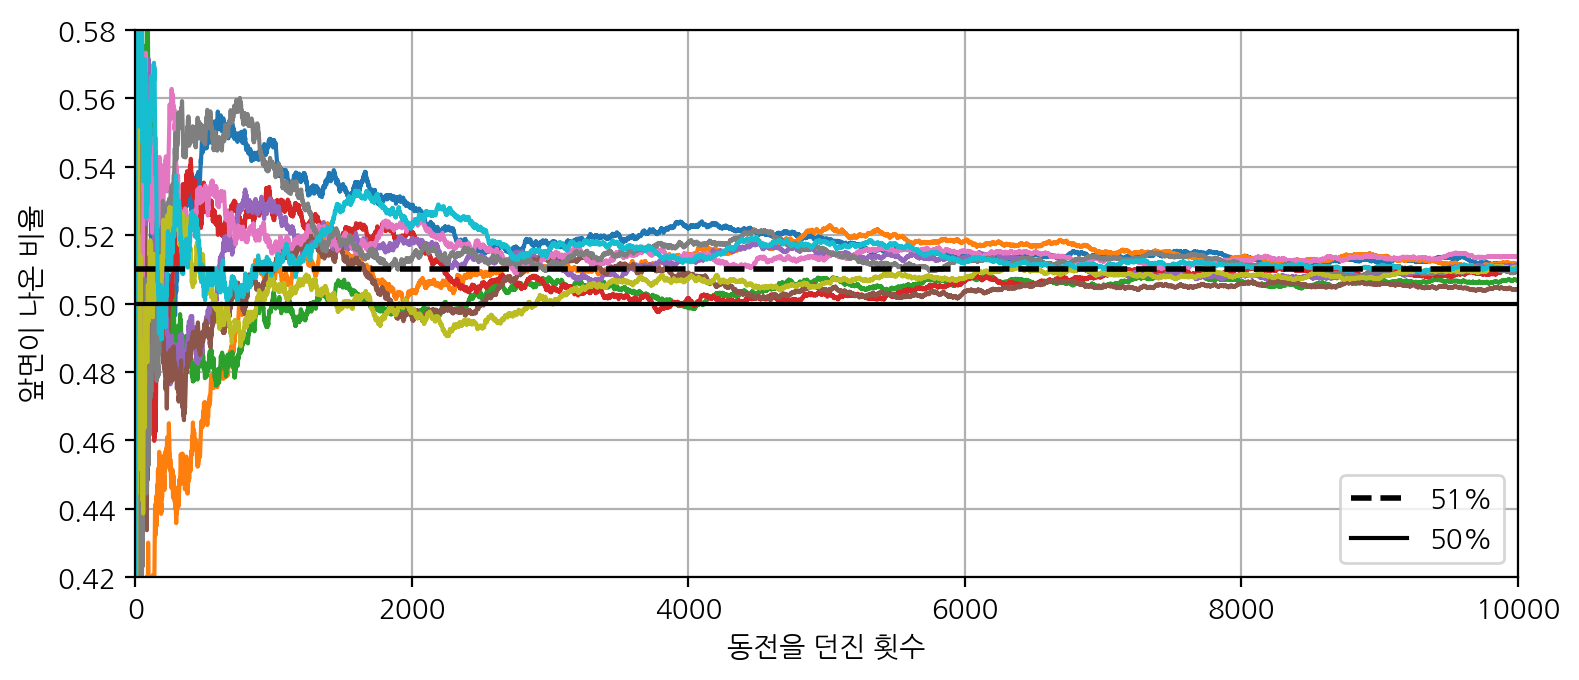

In [5]:
# 추가 코드 - 이 셀은 그림 7-3을 생성하고 저장합니다.

import matplotlib.pyplot as plt
import numpy as np

heads_proba = 0.51
np.random.seed(42)
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads = coin_tosses.cumsum(axis=0)
cumulative_heads_ratio = cumulative_heads / np.arange(1, 10001).reshape(-1, 1)

plt.figure(figsize=(8, 3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("동전을 던진 횟수")
plt.ylabel("앞면이 나온 비율")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.grid()
save_fig("law_of_large_numbers_plot")
plt.show()

투표 기반 분류기를 만들어 보겠습니다:

In [6]:
# 필요한 라이브러리들을 임포트합니다.
from sklearn.datasets import make_moons  # 달 모양의 데이터셋 생성을 위한 함수
from sklearn.ensemble import RandomForestClassifier, VotingClassifier  # 앙상블 모델들
from sklearn.linear_model import LogisticRegression  # 로지스틱 회귀 모델
from sklearn.model_selection import train_test_split  # 데이터 분할 함수
from sklearn.svm import SVC  # 서포트 벡터 머신 분류기

# 달 모양의 데이터셋을 생성합니다. 500개의 샘플과 0.30의 노이즈를 가집니다.
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)

# 데이터를 훈련 세트와 테스트 세트로 분할합니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# VotingClassifier를 생성합니다. 이는 여러 분류기의 예측을 결합하는 앙상블 모델입니다.
voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),  # 로지스틱 회귀
        ('rf', RandomForestClassifier(random_state=42)),  # 랜덤 포레스트
        ('svc', SVC(random_state=42))  # 서포트 벡터 머신
    ]
)

# 생성된 VotingClassifier를 훈련 데이터로 학습시킵니다.
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [7]:
# VotingClassifier의 각 분류기별 성능을 평가합니다.
for name, clf in voting_clf.named_estimators_.items():
    # name: 분류기의 이름 (예: 'lr', 'rf', 'svc')
    # clf: 해당 분류기 객체
    
    # 각 분류기의 테스트 세트에 대한 정확도를 계산합니다.
    accuracy = clf.score(X_test, y_test)
    
    # 분류기 이름과 정확도를 출력합니다.
    print(f"{name} = {accuracy:.4f}")

lr = 0.8640
rf = 0.8960
svc = 0.8960


In [8]:
voting_clf.predict(X_test[:1])

array([1])

In [9]:
[clf.predict(X_test[:1]) for clf in voting_clf.estimators_]

[array([1]), array([1]), array([0])]

In [10]:
voting_clf.score(X_test, y_test)

0.912

이제 간접 투표를 사용해 보겠습니다:

In [11]:
# 투표 방식을 '소프트'로 변경합니다. 이는 각 분류기의 클래스 확률을 평균 내어 최종 예측을 결정합니다.
voting_clf.voting = "soft"

# SVC 분류기에 대해 확률 추정을 활성화합니다. 
# 이는 소프트 투표에 필요한 클래스 확률을 제공하기 위함입니다.
voting_clf.named_estimators["svc"].probability = True

# 변경된 설정으로 모델을 다시 학습시킵니다.
voting_clf.fit(X_train, y_train)

# 테스트 세트에 대한 모델의 정확도를 계산하고 출력합니다.
# 이 점수는 소프트 투표 방식을 사용한 앙상블 모델의 성능을 나타냅니다.
accuracy = voting_clf.score(X_test, y_test)
print(f"소프트 투표 방식의 정확도: {accuracy:.3f}")

소프트 투표 방식의 정확도: 0.920


# 배깅과 페이스팅
## 사이킷런의 배깅과 페이스팅

In [12]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            max_samples=100, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

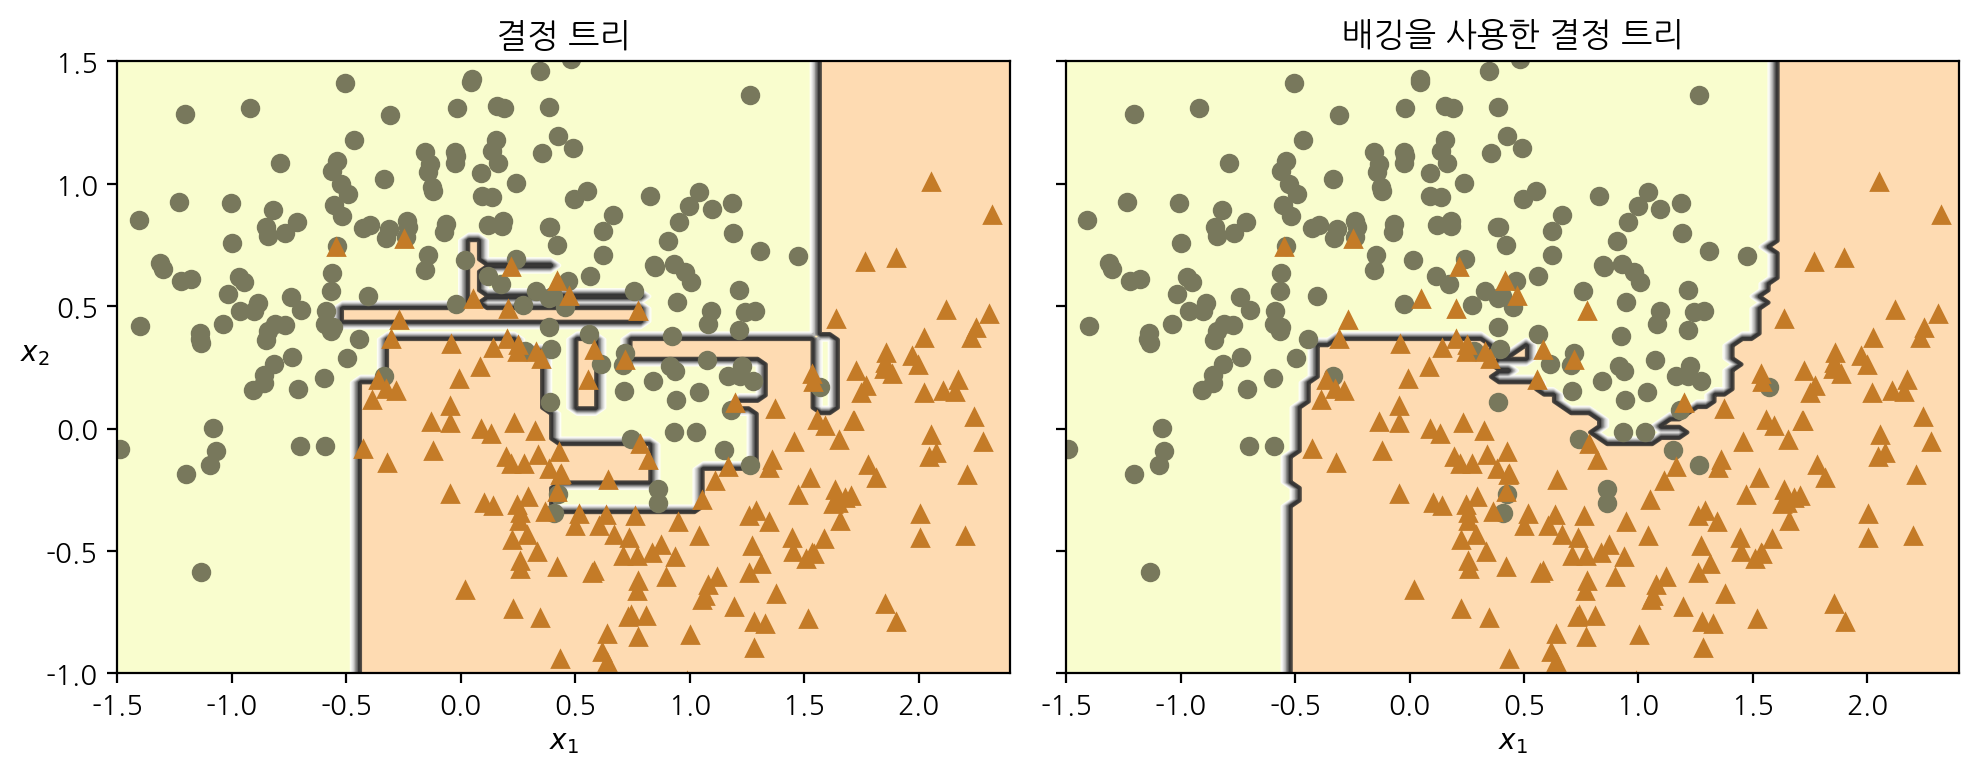

In [13]:
# 추가 코드 - 이 셀은 그림 7-5를 생성하고 저장합니다.

def plot_decision_boundary(clf, X, y, alpha=1.0):
    axes=[-1.5, 2.4, -1, 1.5]
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)

    plt.contourf(x1, x2, y_pred, alpha=0.3 * alpha, cmap='Wistia')
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8 * alpha)
    colors = ["#78785c", "#c47b27"]
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X_train, y_train)
plt.title("결정 트리")
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X_train, y_train)
plt.title("배깅을 사용한 결정 트리")
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

## OOB 평가

In [14]:
# BaggingClassifier를 생성합니다.
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),  # 기본 추정기로 결정 트리를 사용합니다.
    n_estimators=500,  # 앙상블에 포함될 결정 트리의 개수를 500개로 설정합니다.
    oob_score=True,  # Out-of-Bag 평가를 활성화합니다.
    n_jobs=-1,  # 가능한 모든 CPU 코어를 사용하여 병렬 처리를 수행합니다.
    random_state=42  # 재현 가능성을 위해 난수 시드를 설정합니다.
)

# 모델을 훈련 데이터에 맞춥니다.
bag_clf.fit(X_train, y_train)

# Out-of-Bag 점수를 출력합니다.
# 이 점수는 훈련에 사용되지 않은 샘플들로 계산된 모델의 정확도를 나타냅니다.
print("Out-of-Bag 점수:", bag_clf.oob_score_)

Out-of-Bag 점수: 0.896


In [15]:
# OOB 결정 함수 값을 확인합니다.
# 이는 각 샘플에 대한 클래스별 확률 추정치를 나타냅니다.
# [:3]은 처음 3개의 샘플에 대한 결과만 보여줍니다.
oob_probas = bag_clf.oob_decision_function_[:3]

# 결과 출력
print("처음 3개 샘플의 OOB 결정 함수 값:")
print(oob_probas)

# 각 행은 하나의 샘플을 나타내며, 
# 각 열은 해당 클래스에 속할 확률을 나타냅니다.
# 이 값들은 OOB 샘플들만을 사용하여 계산되었습니다.

처음 3개 샘플의 OOB 결정 함수 값:
[[0.32352941 0.67647059]
 [0.3375     0.6625    ]
 [1.         0.        ]]


In [16]:
# sklearn.metrics에서 정확도 점수를 계산하는 함수를 가져옵니다
from sklearn.metrics import accuracy_score

# 배깅 분류기를 사용하여 테스트 데이터에 대한 예측을 수행합니다
y_pred = bag_clf.predict(X_test)

# 예측 결과와 실제 테스트 레이블을 비교하여 정확도를 계산합니다
# 이 점수는 모델이 테스트 데이터에 대해 얼마나 정확하게 예측했는지를 나타냅니다
accuracy = accuracy_score(y_test, y_pred)

# 계산된 정확도를 출력합니다
print(f"배깅 분류기의 테스트 세트 정확도: {accuracy:.3f}")

배깅 분류기의 테스트 세트 정확도: 0.920


크기가 _m_인 데이터셋에서 하나의 샘플을 무작위로 뽑는 경우, 데이터셋의 각 샘플이 선택될 확률은 1/_m_ 이므로 선택되지 않을 확률은 1 - 1/_m_ 입니다. 중복을 허용하여 _m_ 개의 샘플을 뽑는 경우, 모든 추첨은 독립적이므로 각 샘플의 선택되지 않을 확률은 (1 - 1/_m_)<sup>_m_</sup> 입니다. 이제 _m_ 이 무한대에 가까워지면 exp(_x_)가 (1 + _x_/_m_)<sup>_m_</sup>의 극한과 같다는 사실을 이용해 보겠습니다. 따라서 _m_ 이 크면 OOB 샘플의 비율은 약 exp(-1) ≈ 0.37이 됩니다. 따라서 대략 63%(1 - 0.37)가 샘플링됩니다.

In [17]:
# 추가 코드 - 63% 확률을 계산하는 방법을 보여줍니다.
print(1 - (1 - 1 / 1000) ** 1000)
print(1 - np.exp(-1))

0.6323045752290363
0.6321205588285577


# 랜덤 포레스트

In [19]:
# sklearn.ensemble에서 RandomForestClassifier를 가져옵니다
from sklearn.ensemble import RandomForestClassifier

# RandomForestClassifier 객체를 생성합니다
# n_estimators=500: 500개의 결정 트리를 생성합니다
# max_leaf_nodes=16: 각 트리의 최대 리프 노드 수를 16개로 제한합니다
# n_jobs=-1: 가능한 모든 CPU 코어를 사용하여 병렬 처리를 수행합니다
# random_state=42: 재현 가능한 결과를 위해 랜덤 시드를 설정합니다
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16,
                                 n_jobs=-1, random_state=42)

# 훈련 데이터를 사용하여 랜덤 포레스트 모델을 학습시킵니다
rnd_clf.fit(X_train, y_train)

# 학습된 모델을 사용하여 테스트 데이터에 대한 예측을 수행합니다
y_pred_rf = rnd_clf.predict(X_test)

랜덤 포레스트는 결정 트리의 배깅과 같습니다:

In [20]:
# BaggingClassifier를 생성합니다
bag_clf = BaggingClassifier(
    # 기본 추정기로 DecisionTreeClassifier를 사용합니다
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500,  # 500개의 결정 트리를 생성합니다
    n_jobs=-1,  # 모든 가용 CPU를 사용하여 병렬 처리를 수행합니다
    random_state=42  # 재현 가능한 결과를 위해 랜덤 시드를 설정합니다
)

In [21]:
# 추가 코드 - 배깅 분류기와 랜덤 포레스트의 예측 결과를 비교합니다.

# 배깅 분류기를 훈련 데이터로 학습시킵니다.
bag_clf.fit(X_train, y_train)

# 배깅 분류기로 테스트 데이터에 대한 예측을 수행합니다.
y_pred_bag = bag_clf.predict(X_test)

# 배깅 분류기와 랜덤 포레스트의 예측 결과가 완전히 동일한지 확인합니다.
# np.all() 함수는 모든 요소가 True일 때만 True를 반환합니다.
# 즉, 모든 예측이 동일해야 True가 됩니다.
예측_일치 = np.all(y_pred_bag == y_pred_rf)

print(f"배깅 분류기와 랜덤 포레스트의 예측이 동일한가요? {예측_일치}")

배깅 분류기와 랜덤 포레스트의 예측이 동일한가요? True


## 특성 중요도

In [22]:
# sklearn.datasets에서 load_iris 함수를 가져옵니다
from sklearn.datasets import load_iris

# 붓꽃 데이터셋을 DataFrame 형태로 불러옵니다
iris = load_iris(as_frame=True)

# 500개의 트리를 가진 랜덤 포레스트 분류기를 생성합니다
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)

# 랜덤 포레스트 모델을 붓꽃 데이터로 학습시킵니다
rnd_clf.fit(iris.data, iris.target)

# 각 특성의 중요도와 이름을 출력합니다
for score, name in zip(rnd_clf.feature_importances_, iris.data.columns):
    print(round(score, 2), name)

0.11 sepal length (cm)
0.02 sepal width (cm)
0.44 petal length (cm)
0.42 petal width (cm)


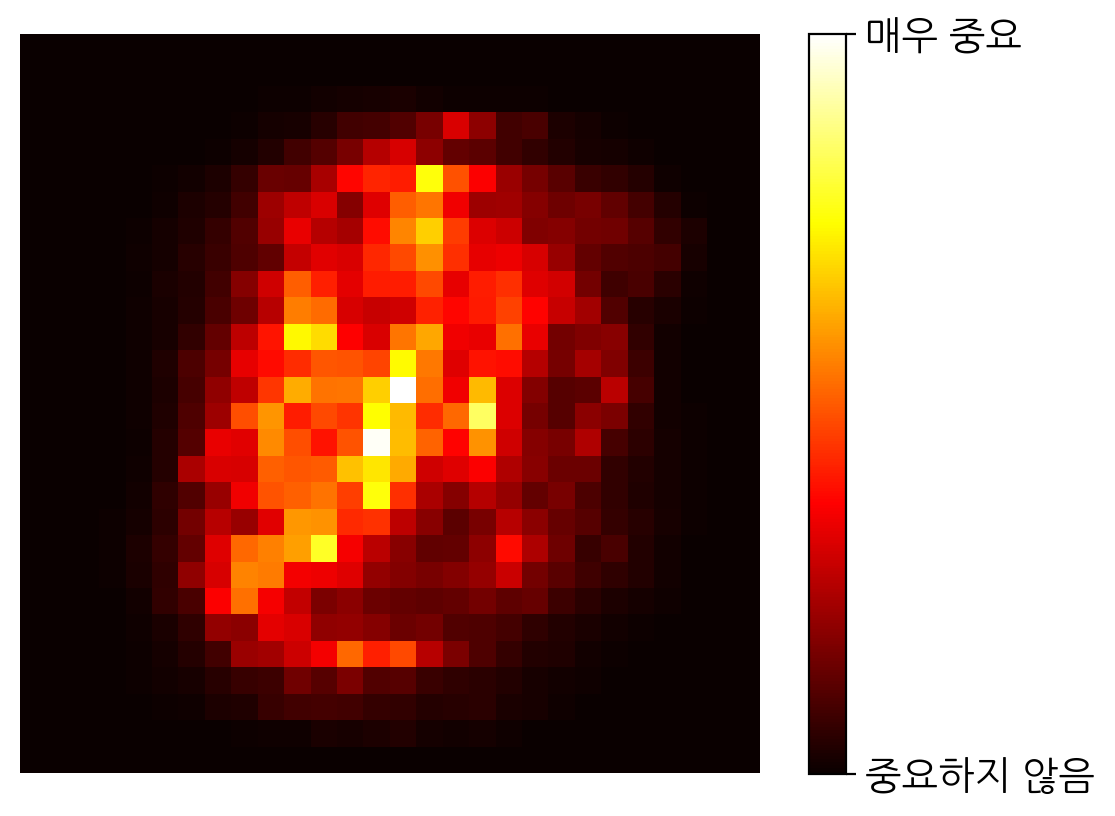

In [23]:
# 추가 코드 - 이 셀은 그림 7-6을 생성하고 저장합니다.

# MNIST 데이터셋을 가져옵니다.
from sklearn.datasets import fetch_openml

# 사이킷런 1.4버전에서 parser 매개변수 기본값이 'liac-arff'에서 'auto'로 바뀌었습니다.
# 이전 버전에서도 동일한 결과를 내도록 명시적으로 'auto'로 지정합니다.
X_mnist, y_mnist = fetch_openml('mnist_784', return_X_y=True,
                                as_frame=False, parser='auto')

# 랜덤 포레스트 분류기를 생성하고 학습시킵니다.
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(X_mnist, y_mnist)

# 특성 중요도를 28x28 이미지 형태로 변환합니다.
heatmap_image = rnd_clf.feature_importances_.reshape(28, 28)

# 히트맵을 그립니다.
plt.imshow(heatmap_image, cmap="hot")

# 컬러바를 추가하고 설정합니다.
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(),
                           rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['중요하지 않음', '매우 중요'], fontsize=14)

# 축을 제거하여 이미지만 보이도록 합니다.
plt.axis("off")

# 그림을 저장하려면 아래 주석을 해제하세요.
# save_fig("mnist_feature_importance_plot")

# 그림을 화면에 표시합니다.
plt.show()

# 부스팅
## AdaBoost

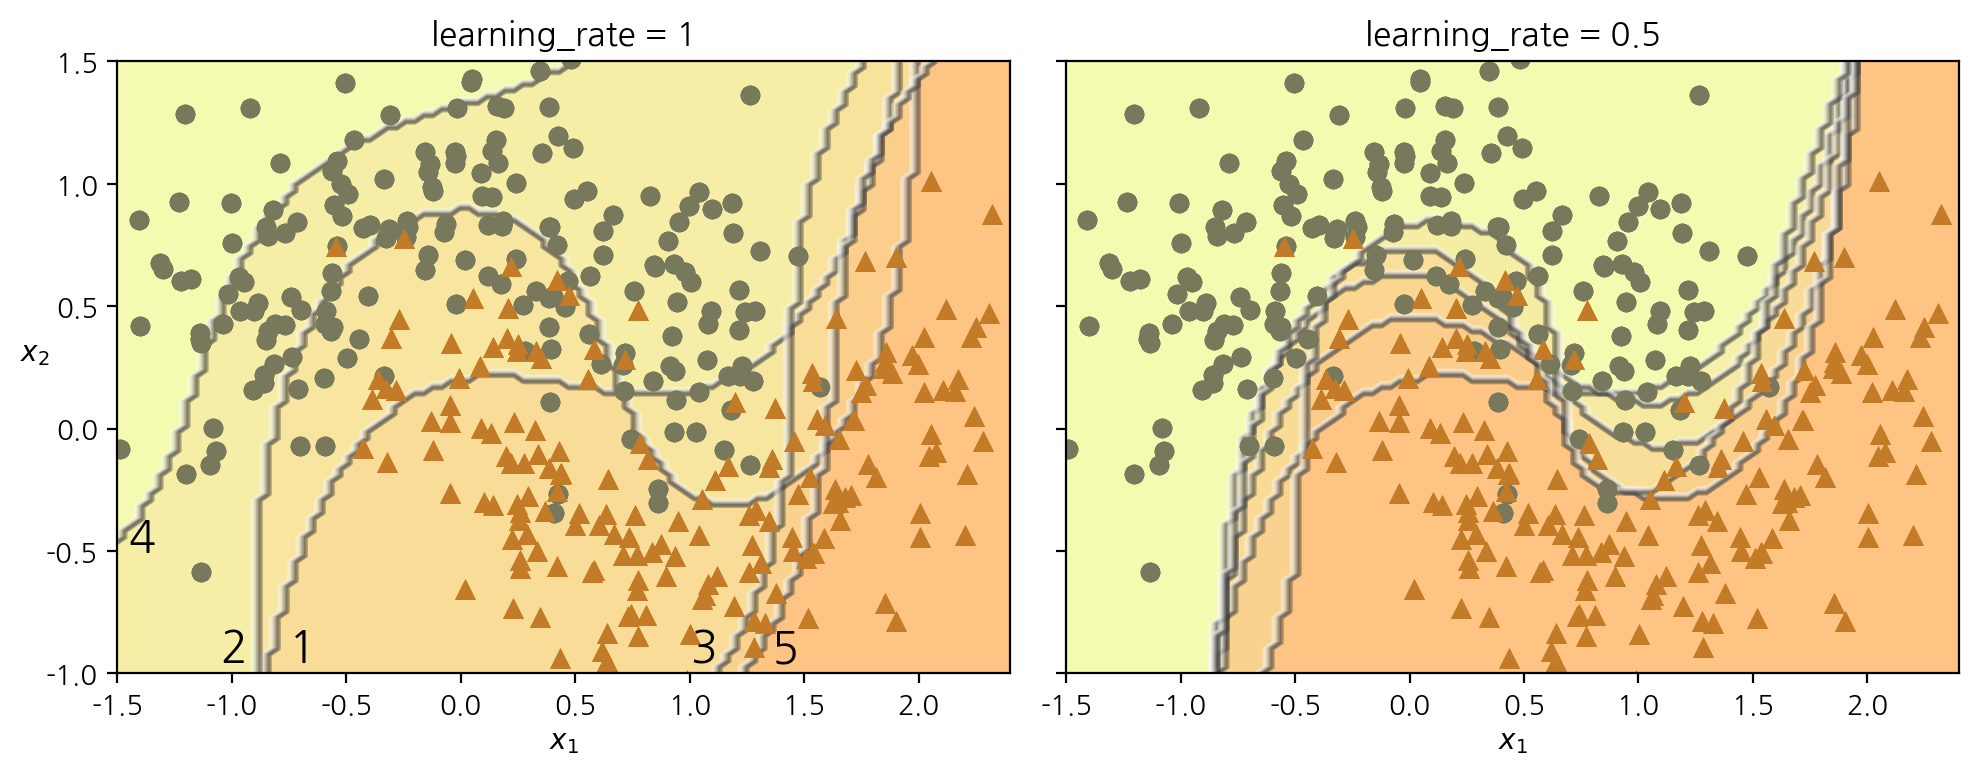

In [24]:
# 추가 코드 - 이 셀은 그림 7-8을 생성하고 저장합니다.

m = len(X_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)

        error_weights = sample_weights[y_pred != y_train].sum()
        r = error_weights / sample_weights.sum()  # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r)  # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha)  # equation 7-3
        sample_weights /= sample_weights.sum()  # normalization step

        plot_decision_boundary(svm_clf, X_train, y_train, alpha=0.4)
        plt.title(f"learning_rate = {learning_rate}")
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=16)
        plt.text(-1.05, -0.95, "2", fontsize=16)
        plt.text(1.0, -0.95, "3", fontsize=16)
        plt.text(-1.45, -0.5, "4", fontsize=16)
        plt.text(1.36,  -0.95, "5", fontsize=16)
    else:
        plt.ylabel("")

save_fig("boosting_plot")
plt.show()

In [25]:
# sklearn.ensemble에서 AdaBoostClassifier를 가져옵니다
from sklearn.ensemble import AdaBoostClassifier

# AdaBoostClassifier 객체를 생성합니다
# - 기본 추정기로 깊이가 1인 결정 트리를 사용합니다
# - 30개의 추정기를 사용합니다
# - 학습률은 0.5로 설정합니다
# - 랜덤 시드는 42로 고정합니다
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=30,
    learning_rate=0.5, random_state=42)

# 훈련 데이터를 사용하여 AdaBoost 분류기를 학습시킵니다
ada_clf.fit(X_train, y_train)

/home/restful3/anaconda3/envs/handson/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=30, random_state=42)

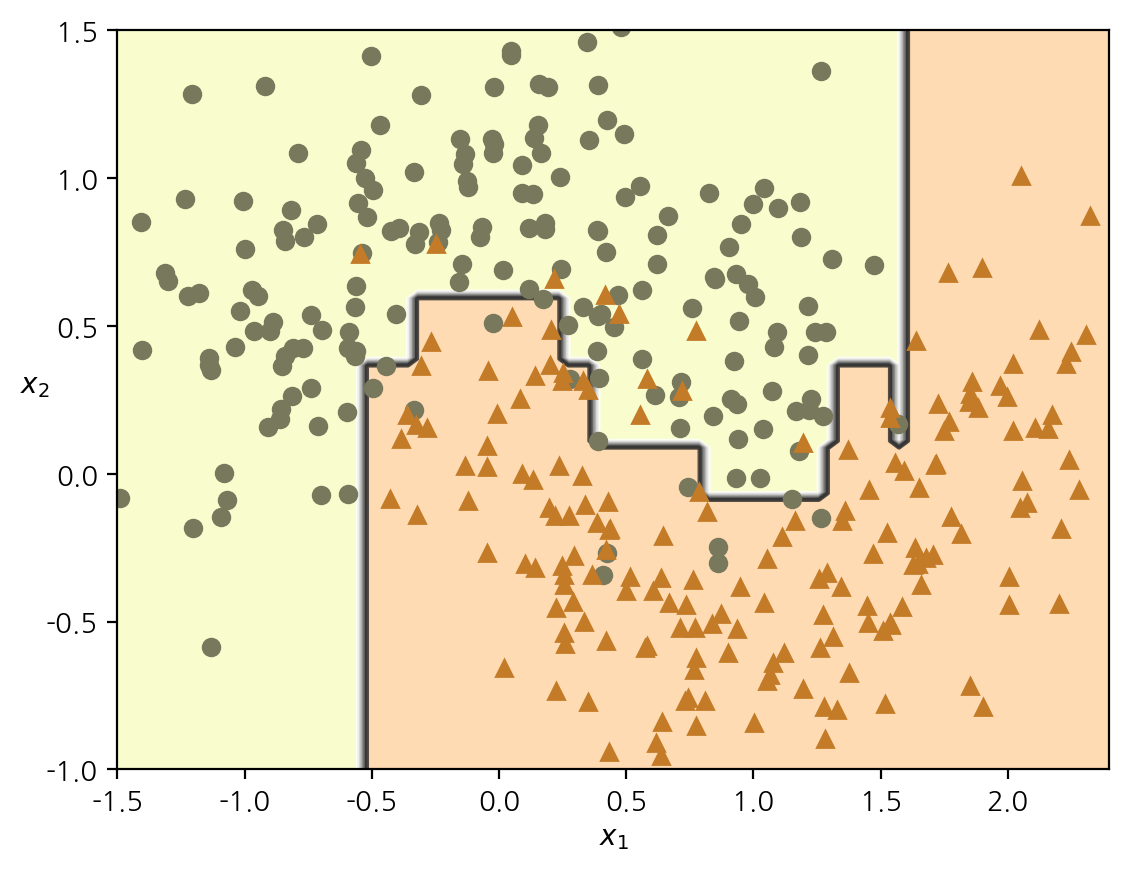

In [26]:
# 추가 코드 - AdaBoost 분류기에 대한 결정 경계가 어떻게 보이는지 궁금한 경우
plot_decision_boundary(ada_clf, X_train, y_train)

## 그레이디언트 부스팅

간단한 2차방정식 데이터셋을 만들고 여기에 `DecisionTreeRegressor`를 훈련시켜 보겠습니다:

In [27]:
# numpy와 DecisionTreeRegressor를 임포트합니다
import numpy as np
from sklearn.tree import DecisionTreeRegressor

# 재현성을 위해 랜덤 시드를 설정합니다
np.random.seed(42)

# 100개의 샘플로 구성된 1차원 특성 데이터를 생성합니다 (범위: -0.5 ~ 0.5)
X = np.random.rand(100, 1) - 0.5

# 2차 함수에 약간의 가우시안 노이즈를 추가하여 타겟 데이터를 생성합니다
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)  # y = 3x² + 가우시안 노이즈

# 최대 깊이가 2인 결정 트리 회귀 모델을 생성합니다
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)

# 모델을 데이터에 맞춥니다
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

이제 이전 예측기가 만든 잔여 오차에 대해 다른 결정 트리 회귀를 훈련해 보겠습니다:

In [28]:
# 첫 번째 트리의 예측을 원본 타겟에서 빼서 잔여 오차를 계산합니다
y2 = y - tree_reg1.predict(X)

# 두 번째 결정 트리 회귀 모델을 생성합니다 (최대 깊이 2)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=43)

# 두 번째 트리를 잔여 오차에 대해 학습시킵니다
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=43)

In [29]:
# 두 번째 트리의 예측을 첫 번째 잔여 오차에서 빼서 두 번째 잔여 오차를 계산합니다
y3 = y2 - tree_reg2.predict(X)

# 세 번째 결정 트리 회귀 모델을 생성합니다 (최대 깊이 2)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=44)

# 세 번째 트리를 두 번째 잔여 오차에 대해 학습시킵니다
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=44)

In [30]:
# 새로운 데이터 포인트를 생성합니다
X_new = np.array([[-0.4], [0.], [0.5]])

# 세 개의 트리 모델의 예측을 합산합니다
# 이는 그래디언트 부스팅의 기본 아이디어를 보여줍니다:
# 여러 모델의 예측을 순차적으로 더해 최종 예측을 만듭니다
sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

array([0.49484029, 0.04021166, 0.75026781])

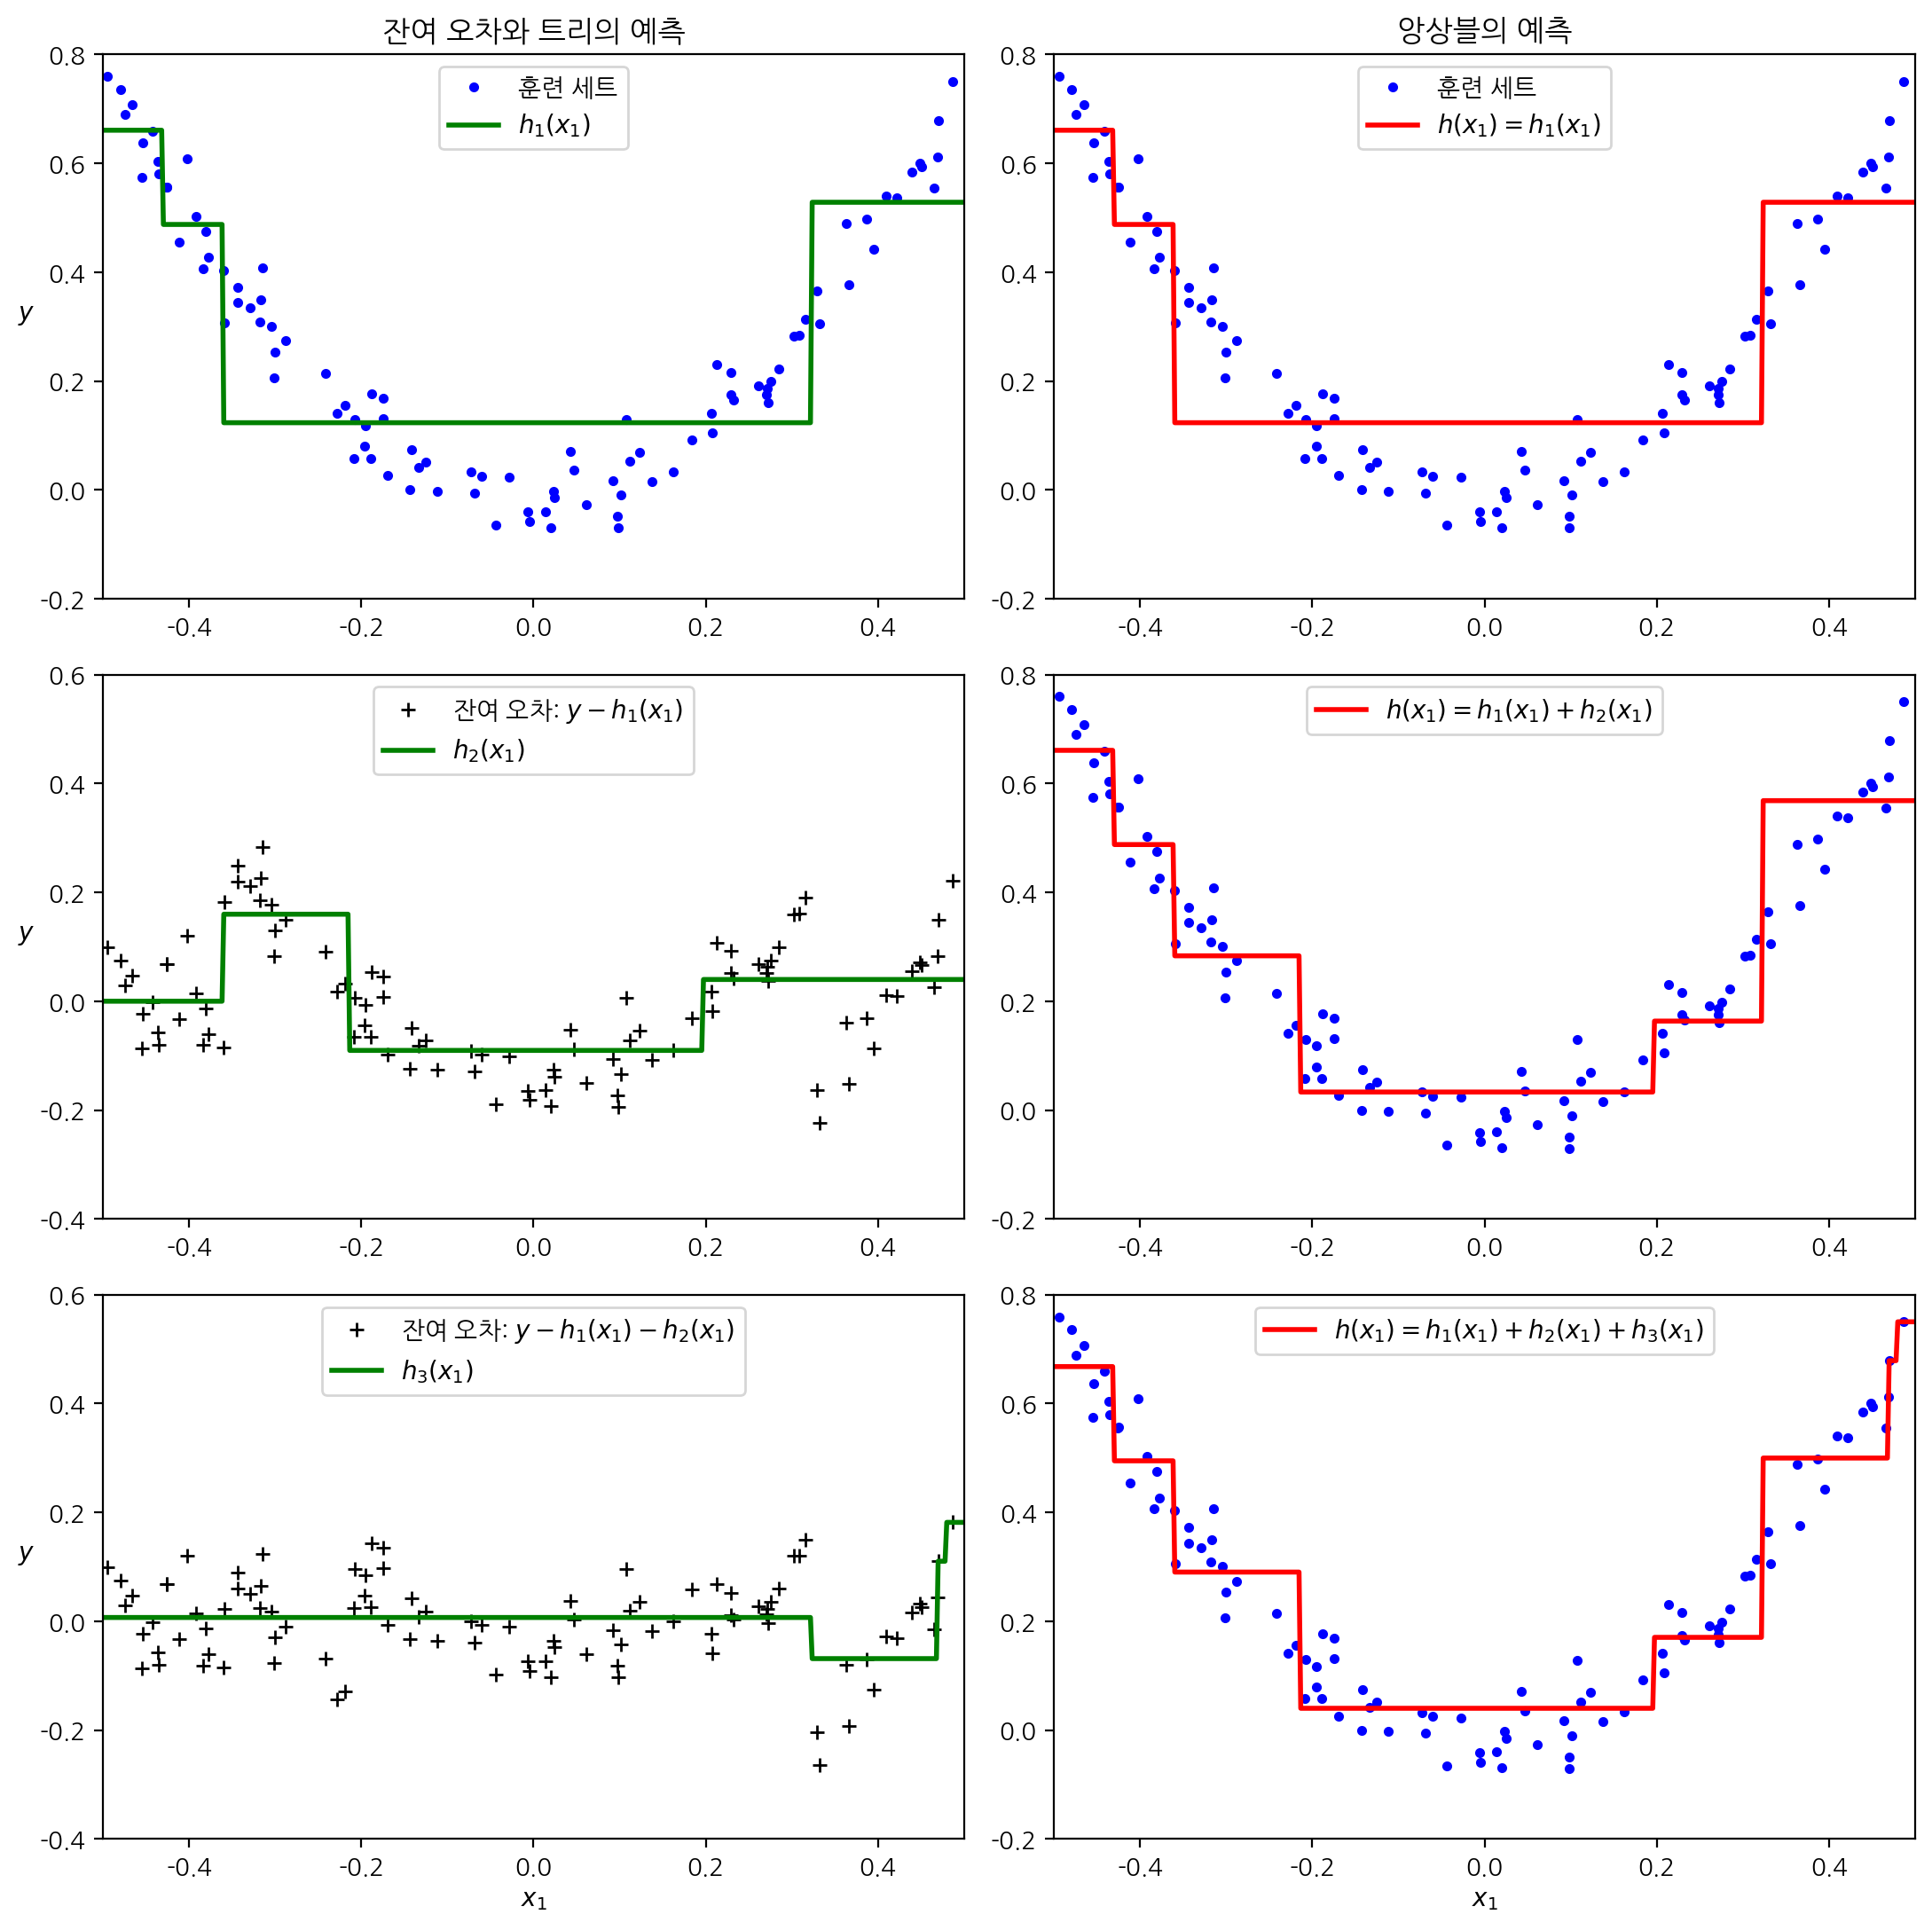

In [31]:
# 그림 7-9를 생성하고 저장하는 코드

# 예측을 플롯하는 함수 정의
def plot_predictions(regressors, X, y, axes, style,
                     label=None, data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1))
                 for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center")
    plt.axis(axes)

# 그림 크기 설정
plt.figure(figsize=(11, 11))

# 첫 번째 서브플롯: 첫 번째 트리의 예측과 실제 데이터
plt.subplot(3, 2, 1)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="g-",
                 label="$h_1(x_1)$", data_label="훈련 세트")
plt.ylabel("$y$  ", rotation=0)
plt.title("잔여 오차와 트리의 예측")

# 두 번째 서브플롯: 첫 번째 트리의 예측 (앙상블의 첫 단계)
plt.subplot(3, 2, 2)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1)$", data_label="훈련 세트")
plt.title("앙상블의 예측")

# 세 번째 서브플롯: 두 번째 트리의 예측과 첫 번째 잔여 오차
plt.subplot(3, 2, 3)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_2(x_1)$", data_style="k+",
                 data_label="잔여 오차: $y - h_1(x_1)$")
plt.ylabel("$y$  ", rotation=0)

# 네 번째 서브플롯: 첫 번째와 두 번째 트리의 예측 합
plt.subplot(3, 2, 4)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.2, 0.8],
                  style="r-", label="$h(x_1) = h_1(x_1) + h_2(x_1)$")

# 다섯 번째 서브플롯: 세 번째 트리의 예측과 두 번째 잔여 오차
plt.subplot(3, 2, 5)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_3(x_1)$", data_style="k+",
                 data_label="잔여 오차: $y - h_1(x_1) - h_2(x_1)$")
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)

# 여섯 번째 서브플롯: 세 트리의 예측 합 (최종 앙상블)
plt.subplot(3, 2, 6)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y,
                 axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$")

# 그림 저장 및 표시
save_fig("gradient_boosting_plot")
plt.show()

이제 그레이디언트 부스팅 회귀를 시도해 보겠습니다:

In [32]:
# sklearn.ensemble에서 GradientBoostingRegressor 가져오기
from sklearn.ensemble import GradientBoostingRegressor

# GradientBoostingRegressor 모델 생성
# max_depth=2: 각 트리의 최대 깊이
# n_estimators=3: 트리의 개수
# learning_rate=1.0: 학습률
# random_state=42: 재현성을 위한 난수 시드
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3,
                                 learning_rate=1.0, random_state=42)

# 모델을 훈련 데이터에 맞춤
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [33]:
# 최적의 GradientBoostingRegressor 모델 생성
# max_depth=2: 각 트리의 최대 깊이를 2로 제한
# learning_rate=0.05: 학습률을 0.05로 설정하여 천천히 학습
# n_estimators=500: 최대 500개의 트리를 사용
# n_iter_no_change=10: 10번 연속으로 성능 향상이 없으면 조기 종료
# random_state=42: 재현성을 위한 난수 시드
gbrt_best = GradientBoostingRegressor(
    max_depth=2, learning_rate=0.05, n_estimators=500,
    n_iter_no_change=10, random_state=42)

# 모델을 훈련 데이터에 맞춤
gbrt_best.fit(X, y)

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=500,
                          n_iter_no_change=10, random_state=42)

In [39]:
# gbrt_best 모델의 최종 트리 개수 출력
# n_estimators_ 속성은 실제로 사용된 트리의 수를 나타냄
# 조기 종료로 인해 설정한 최대 트리 수보다 적을 수 있음
gbrt_best.n_estimators_

92

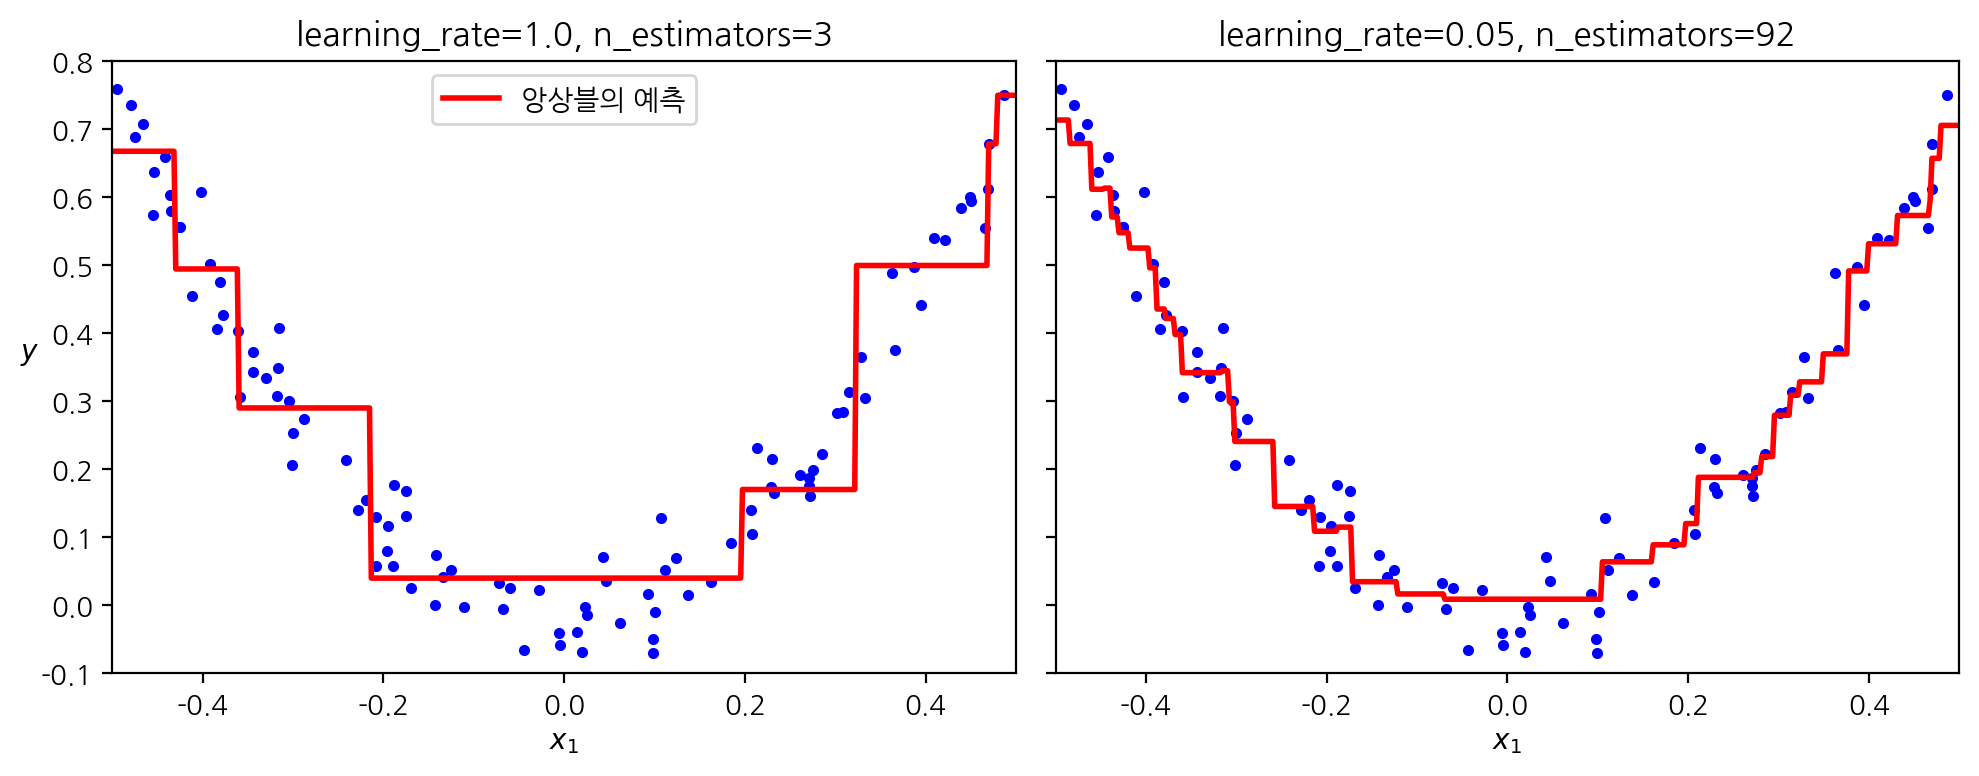

In [35]:
# 그림 7-10을 생성하고 저장하는 코드입니다.

# 2개의 서브플롯이 있는 그림을 생성합니다. 가로로 배치되며 크기는 10x4입니다.
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

# 첫 번째 서브플롯 설정
plt.sca(axes[0])
# gbrt 모델의 예측을 플롯합니다.
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-",
                 label="앙상블의 예측")
# 제목 설정: 학습률과 트리 개수 표시
plt.title(f"learning_rate={gbrt.learning_rate}, "
          f"n_estimators={gbrt.n_estimators_}")
plt.xlabel("$x_1$")  # x축 레이블
plt.ylabel("$y$", rotation=0)  # y축 레이블, 회전 없음

# 두 번째 서브플롯 설정
plt.sca(axes[1])
# gbrt_best 모델의 예측을 플롯합니다.
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-")
# 제목 설정: 학습률과 트리 개수 표시
plt.title(f"learning_rate={gbrt_best.learning_rate}, "
          f"n_estimators={gbrt_best.n_estimators_}")
plt.xlabel("$x_1$")  # x축 레이블

# 그림을 파일로 저장
save_fig("gbrt_learning_rate_plot")
# 그림 표시
plt.show()

In [36]:
# 추가 코드 - 2장에서 설명했습니다.

# 필요한 라이브러리 임포트
import pandas as pd
from sklearn.model_selection import train_test_split
import tarfile
import urllib.request

# 주택 데이터를 로드하는 함수 정의
def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        # 데이터셋 디렉토리가 없으면 생성
        Path("datasets").mkdir(parents=True, exist_ok=True)
        # GitHub에서 데이터 다운로드
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        # 다운로드한 tar 파일 압축 해제
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    # CSV 파일 읽어서 반환
    return pd.read_csv(Path("datasets/housing/housing.csv"))

# 주택 데이터 로드
housing = load_housing_data()

# 훈련 세트와 테스트 세트로 분할 (80:20 비율)
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

# 타겟 변수(주택 가격) 분리
housing_labels = train_set["median_house_value"]
housing = train_set.drop("median_house_value", axis=1)

In [37]:
# 필요한 라이브러리 임포트
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder

# 파이프라인 생성
hgb_reg = make_pipeline(
    # 'ocean_proximity' 열에 대해 OrdinalEncoder 적용, 나머지 열은 그대로 유지
    make_column_transformer((OrdinalEncoder(), ["ocean_proximity"]),
                            remainder="passthrough"),
    # HistGradientBoostingRegressor 모델 생성
    # 첫 번째 특성(ocean_proximity)을 범주형으로 처리하고 랜덤 시드 설정
    HistGradientBoostingRegressor(categorical_features=[0], random_state=42)
)

# 모델 학습
hgb_reg.fit(housing, housing_labels)

/home/restful3/anaconda3/envs/handson/lib/python3.10/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['ocean_proximity'])])),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(categorical_features=[0],
                                               random_state=42))])

In [38]:
# hgb_reg 모델의 RMSE 통계를 평가합니다.

# 교차 검증을 위한 cross_val_score 함수를 가져옵니다.
from sklearn.model_selection import cross_val_score

# 10-겹 교차 검증을 수행하여 RMSE 점수를 계산합니다.
# 음수 RMSE 점수를 사용하므로 결과에 -를 붙여 양수로 변환합니다.
hgb_rmses = -cross_val_score(hgb_reg, housing, housing_labels,
                             scoring="neg_root_mean_squared_error", cv=10)

# RMSE 점수의 통계를 계산하고 출력합니다.
pd.Series(hgb_rmses).describe()

count       10.000000
mean     47613.307194
std       1295.422509
min      44963.213061
25%      47001.233485
50%      48000.963564
75%      48488.093243
max      49176.368465
dtype: float64

# 스태킹

In [40]:
# sklearn.ensemble에서 StackingClassifier 임포트
from sklearn.ensemble import StackingClassifier

# StackingClassifier 객체 생성
stacking_clf = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),  # 로지스틱 회귀 분류기
        ('rf', RandomForestClassifier(random_state=42)),  # 랜덤 포레스트 분류기
        ('svc', SVC(probability=True, random_state=42))  # SVM 분류기 (확률 예측 활성화)
    ],
    final_estimator=RandomForestClassifier(random_state=43),  # 최종 메타 분류기로 랜덤 포레스트 사용
    cv=5  # 5-겹 교차 검증 사용
)

# 스태킹 분류기 학습
stacking_clf.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('lr', LogisticRegression(random_state=42)),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('svc', SVC(probability=True, random_state=42))],
                   final_estimator=RandomForestClassifier(random_state=43))

In [41]:
stacking_clf.score(X_test, y_test)

0.928

# 연습문제 해답

## 1. to 7.

부록 A 참조

## 8. 투표 기반 분류기

문제: _MNIST 데이터를 불러들여 훈련 세트, 검증 세트, 테스트 세트로 나눕니다(예를 들면 훈련에 50,000개 샘플, 검증에 10,000개 샘플, 테스트에 10,000개 샘플)._

MNIST 데이터셋은 앞서 로드했습니다. 이 데이터셋은 이미 훈련 세트(처음 60,000개의 샘플)와 테스트 세트(마지막 10,000개의 샘플)로 분할되어 있으며, 훈련 세트는 이미 뒤섞여 있습니다. 따라서 처음 50,000개의 샘플을 새 훈련 세트에, 다음 10,000개의 샘플을 검증 세트에, 마지막 10,000개의 샘플을 테스트 세트에 사용하기만 하면 됩니다:

In [ ]:
X_train, y_train = X_mnist[:50_000], y_mnist[:50_000]
X_valid, y_valid = X_mnist[50_000:60_000], y_mnist[50_000:60_000]
X_test, y_test = X_mnist[60_000:], y_mnist[60_000:]

문제: _그런 다음 랜덤 포레스트 분류기, 엑스트라 트리 분류기, SVM 분류기 같은 여러 종류의 분류기를 훈련시킵니다._

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

사이킷런 1.5에서 `LinearSVC`의 `dual` 매개변수 기본값이 `True`에서 `"auto"`로 바뀔 예정입니다. 동일한 결과가 유지되도록 명시적으로 `True`로 지정합니다.

In [ ]:
random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
svm_clf = LinearSVC(max_iter=100, tol=20, dual=True, random_state=42)
mlp_clf = MLPClassifier(random_state=42)

In [ ]:
estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
for estimator in estimators:
    print("훈련 모델:", estimator)
    estimator.fit(X_train, y_train)

In [ ]:
[estimator.score(X_valid, y_valid) for estimator in estimators]

선형 SVM은 다른 분류기보다 성능이 훨씬 뛰어납니다. 하지만 투표 기반 분류기의 성능을 향상시킬 수 있으므로 그대로 둡니다.

문제: _그리고 검증 세트에서 개개의 분류기보다 더 높은 성능을 내도록 이들을 간접 또는 직접 투표 방법을 사용해 앙상블로 연결해보세요._

In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("svm_clf", svm_clf),
    ("mlp_clf", mlp_clf),
]

In [ ]:
voting_clf = VotingClassifier(named_estimators)

In [ ]:
voting_clf.fit(X_train, y_train)

In [ ]:
voting_clf.score(X_valid, y_valid)

`VotingClassifier`는 각 분류기의 복제본을 만들어 원래 클래스 이름이 아닌 클래스 인덱스를 레이블로 사용하여 복제본을 훈련시켰습니다. 따라서 이러한 복제본을 평가하려면 클래스 인덱스도 제공해야 합니다. 클래스를 클래스 인덱스로 변환하기 위해 `LabelEncoder`를 사용할 수 있습니다:

In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_valid_encoded = encoder.fit_transform(y_valid)

그러나 MNIST의 경우 숫자가 클래스 ID와 일치하므로 클래스 이름을 정수로 변환하는 것이 더 간단합니다:

In [ ]:
y_valid_encoded = y_valid.astype(np.int64)

이제 분류기 복제본을 평가해 보겠습니다:

In [ ]:
[estimator.score(X_valid, y_valid_encoded)
 for estimator in voting_clf.estimators_]

SVM을 제거하여 성능이 향상되는지 확인해 보겠습니다. 다음과 같이 `set_params()`를 사용하여 `"drop"`으로 설정하여 추정기를 제거할 수 있습니다:

In [ ]:
voting_clf.set_params(svm_clf="drop")

이렇게 하면 추정기 목록이 업데이트됩니다:

In [ ]:
voting_clf.estimators

그러나 _훈련된_ 추정기 목록은 업데이트하지 않습니다:

In [ ]:
voting_clf.estimators_

In [ ]:
voting_clf.named_estimators_

따라서 `VotingClassifier`를 다시 훈련하거나 `estimators_`와 `named_estimators_`에 있는 훈련된 추정기 목록에서 SVM을 제거할 수 있습니다:

In [ ]:
svm_clf_trained = voting_clf.named_estimators_.pop("svm_clf")
voting_clf.estimators_.remove(svm_clf_trained)

이제 `VotingClassifier`를 다시 평가해 보겠습니다:

In [ ]:
voting_clf.score(X_valid, y_valid)

조금 나아졌습니다! SVM이 성능을 저해하고 있었습니다. 이제 간접 투표 분류기를 사용해 보겠습니다. 실제로 분류기를 재학습할 필요 없이 `voting`를 `soft`로 설정하면 됩니다:

In [ ]:
voting_clf.voting = "soft"

In [ ]:
voting_clf.score(X_valid, y_valid)

이런, 이 경우에는 직접 투표 방식이 더 낫군요.

문제: _앙상블을 얻고 나면 테스트 세트로 확인해보세요. 개개의 분류기와 비교해서 성능이 얼마나 향상되나요?_

In [ ]:
voting_clf.voting = "hard"
voting_clf.score(X_test, y_test)

In [ ]:
[estimator.score(X_test, y_test.astype(np.int64))
 for estimator in voting_clf.estimators_]

투표 분류기는 최고 모델의 오류율을 약 3%에서 2.7%로 낮췄으며, 이는 10%의 오류를 줄인 것입니다.

## 9. 스태킹 앙상블

문제: _이전 연습문제의 각 분류기를 실행해서 검증 세트에서 예측을 만들고 그 결과로 새로운 훈련 세트를 만들어보세요. 각 훈련 샘플은 하나의 이미지에 대한 전체 분류기의 예측을 담은 벡터이고 타깃은 이미지의 클래스입니다. 새로운 훈련 세트에 분류기 하나를 훈련시켜보세요._

In [ ]:
X_valid_predictions = np.empty((len(X_valid), len(estimators)), dtype=object)

for index, estimator in enumerate(estimators):
    X_valid_predictions[:, index] = estimator.predict(X_valid)

In [ ]:
X_valid_predictions

In [ ]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True,
                                            random_state=42)
rnd_forest_blender.fit(X_valid_predictions, y_valid)

In [ ]:
rnd_forest_blender.oob_score_

이 블렌더를 미세 조정하거나 다른 유형의 블렌더(예: `MLPClassifier`)를 사용해 본 다음, 항상 그렇듯이 교차 검증을 통해 가장 적합한 블렌더를 선택할 수 있습니다.

문제: _축하합니다. 방금 블렌더를 훈련시켰습니다. 그리고 이 분류기를 모아서 스태킹 앙상블을 구성했습니다! 이제 테스트 세트에 앙상블을 평가해보세요. 테스트 세트의 각 이미지에 대해 모든 분류기로 예측을 만들고 앙상블의 예측 결과를 만들기 위해 블렌더에 그 예측을 주입합니다. 앞서 만든 투표 분류기와 비교하면 어떤가요?_

In [ ]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=object)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [ ]:
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [ ]:
accuracy_score(y_test, y_pred)

이 스태킹 앙상블은 앞서 학습한 투표 기반 분류기보다 성능이 좋지 않습니다.

문제: _이제 `StackingClassifier`를 사용하여 다시 시도해 보세요. 성능이 더 좋아졌나요? 그렇다면 그 이유는 무엇인가요?_

`StackingClassifier`는 K-겹 교차 검증을 사용하기 때문에 별도의 검증 세트가 필요하지 않으므로 훈련 세트와 검증 세트를 더 큰 훈련 세트로 합쳐보겠습니다:

In [ ]:
X_train_full, y_train_full = X_mnist[:60_000], y_mnist[:60_000]

이제 전체 훈련 세트에서 스태킹 분류기를 생성하고 훈련해 보겠습니다:

**경고**: 다음 셀은 기본적으로 5-겹 검증을 사용하기 때문에 실행하는 데 시간이 꽤 오래 걸립니다(하드웨어에 따라 15~30분 정도 소요). 이 셀은 4개의 분류기를 전체 훈련 세트의 80%에 대해 각각 5회씩 훈련하여 예측을 하고, 마지막으로 전체 훈련 세트에 대해 각각 한 번씩 훈련하여 예측에 대한 최종 모델을 훈련합니다. 총 25개의 모델을 훈련해야 합니다!

In [ ]:
stack_clf = StackingClassifier(named_estimators,
                               final_estimator=rnd_forest_blender)
stack_clf.fit(X_train_full, y_train_full)

In [ ]:
stack_clf.score(X_test, y_test)

`StackingClassifier`는 앞서 시도한 사용자 정의 스태킹 구현보다 훨씬 뛰어난 성능을 발휘합니다! 이는 크게 두 가지 이유 때문입니다:

* 검증 세트를 별도로 사용하지 않았기 때문에 더 큰 데이터 집합에 대해 `StackingClassifier`를 학습시켰습니다.
* 사용 가능한 경우 `predict_proba()`를, 그렇지 않으면 `decision_function()`을, 그렇지 않으면 `predict()`를 사용했습니다. 이렇게 하면 블렌더가 훨씬 더 미묘한 입력을 처리할 수 있습니다.

오늘은 여기까지입니다. 이 장의 코드와 연습 문제를 모두 완료하신 것을 축하드립니다!